# Preprocessing Stage

This notebook sets out the steps for running through raw METS/ALTO XML data from newspaper digitisation projects. We collect titles, dates, newspaper names, and raw text.

## Imports

We will use the Python `multiprocessing` library to speed up working through the dataset. `ElementTree` will be used to parse the METS and ALTO format XML files.

In [1]:
import re
import tarfile
import os
import sys
import glob
import time
import pickle
from multiprocessing import Pool

import pandas as pd
import xml.etree.ElementTree as ET

## Preprocessing

The data is stored in METS/ALTO format with a tar ball for each newspaper-year combination. There is a folder for each newspaper. 

We aim to get from METS and ALTO files, which contain a great deal of information about the location of words and blocks on pages, to a dataframe containing details of each article and its text. 

**A note on generalisability:** not all newspaper digitization projects will have this file structure or compression method. Given this, I have tried to separate the functions which rely on this structure from those which do not. The functions which process the METS and ALTO files will have `_inner` in their names. It may take some ingenuity to reuse this code for other similar projects, but this seperation of functions should help.

### Helper functions

There are many steps required to get from tarballs. At the highest level, we open the tarball, determine how many issues it has, collect the files which make up each issue, and then collect each article from the issues.

In [3]:
def process_tarball(filepath):
    """
    Given path to tarball, open and return dataframe containing article
    items from tarball.
    """
    newspaper_year = tarfile.open(filepath)
    files = newspaper_year.getmembers()
    issues = collect_issues(files)
    articles = collect_articles(issues, newspaper_year)

    return articles


Each issue has a code, of the form `NEWSPAPER_YYYYMMDD`, where `NEWSPAPER` is replaced with the newspaper's code. Each will have a METS file with the details of the issue as a whole along with an ALTO file for each page. We collect the files which make up each issue.

In [4]:
def collect_issues(files):
    """
    Given list of files in tarball, return a dictionary keyed
    by the issue code with list of xml files of form [0001.xml, ..., mets.xml]
    as values.
    """
    issues = {}
    issue_code = ''
    for file in files:
        match = re.search("[A-Z]*_\d{8}$", file.name)
        if match:
            issue_code = match.group(0)
        if file.name.endswith('.xml'):
            xml_list = issues.get(issue_code, [])
            xml_list.append(file)
            issues[issue_code] = xml_list
    return issues

Given a list of issues, we collect the articles which make up each issue. This is done by first looking in the METS file for the article names and their corresponding text blocks in the ALTO files (`mets2codes()`) and then by collecting the text corresponding to each article (`codes2text()`).

In [5]:
def collect_articles(issues, newspaper_year):
    """Given list of issues and corresponding xml files,
    return dictionary containing article codes as keys and
    texts (as list of strings for each block as values."""
    articles = {}
    for issue_code, issue_files in issues.items():
        mets_tarinfo = issue_files[-1]
        pages_tarinfo = issue_files[0:-1]
        article_codes = mets2codes(mets_tarinfo, newspaper_year)
        all_articles = codes2texts(article_codes, pages_tarinfo, newspaper_year, issue_code)
        articles = {**articles, **all_articles} # Merge dictionaries.

    return articles

The following helper functions, which perform the XML parsing steps will be given here without detailed commentary. ***NB: mets2codes excludes all 'advertising'***

In [6]:
def mets2codes_inner(text, newspaper_year):
    """
    Given METS file as text string, return a dictionary of
    articles, with article does as keys and, as values, tuples containing
    the corresponding article title and a list of text blocks from the 
    corresponding ALTO files as values.
    """
    
    mets_root = ET.fromstring(text)
    logical_structure = mets_root.find("./mets:structMap[@LABEL='Logical Structure']", NS)
    articles = logical_structure.findall(".//mets:div[@TYPE='ARTICLE']", NS)

    art_dict = {}
    for article in articles:

        attributes = article.attrib
        article_id = attributes['DMDID']
        article_title = attributes.get('LABEL', 'UNTITLED')

        text_blocks = article.findall(".//mets:div[@TYPE='TEXT']", NS)
        block_ids = []
        for block in text_blocks:
            try:
                area = block.find(".//mets:area", NS)
                block_id = area.attrib['BEGIN']
                block_ids.append(block_id)
            except AttributeError:
                print(f'Error in {newspaper_year}')
        art_dict[article_id] = (article_title, block_ids)

    mets_root.clear()

    return art_dict


    
def mets2codes(mets_tarinfo, newspaper_year):
    """
    Given mets as tarinfo, return text block codes for articles
    contained in mets file. Edited for processing with tarfile
    object newspaper_year.

    Returns dictionary of article codes as keys,
    with a 2-tuple containing the article title
    and a list of corresponding text block codes as values.
    """
    with newspaper_year.extractfile(mets_tarinfo) as file:
        text = file.read()
        
    art_dict = mets2codes_inner(text, newspaper_year)

    return art_dict



def codes2texts_inner(article_codes, page_roots, issue_code):
    """
    Given XML roots of ALTO pages and collection of article codes
    and corresponding blocks, return a distionary with article codes 
    as keys and a list of text blocks as strings as values.
    """
    
    texts_dict = {}
    for article_id in article_codes.keys():
        title, blocks = article_codes[article_id]
        text = []
        for block in blocks:
            end_loc = block.find('_')
            page_no = block[0:end_loc]
            page_root = page_roots[page_no]
            xml_block = page_root.find(f".//TextBlock[@ID='{block}']")
            block_strings = xml_block.findall('.//String')
            block_as_string = process_block(block_strings)
            text.append(block_as_string)
        issue_article_id = issue_code + '_' + article_id[7:]
        texts_dict[issue_article_id] = (title, text)
        
    return texts_dict

    

def codes2texts(article_codes, pages_tarinfo, newspaper_year, issue_code):
    """
    Given article codes, the issue pages as tar info objects, 
    the newspaper year and the issue code, return a dictionary
    with article codes as keys and a list of text blocks as
    strings as values.
    """

    page_roots = parse_pages_tar(pages_tarinfo, newspaper_year)
    # page_roots returns a dictionary with pages numbers (of form 'P1'
    # etc...) as keys and the XML roots of the pages as values.

    texts_dict = codes2texts_inner(article_codes, page_roots, issue_code)

    # Clear roots.
    for i in range(len(page_roots)):
        k, v = page_roots.popitem()
        v.clear()

    return texts_dict



def parse_pages_tar(pages, newspaper_year):
    """
    Given iterable of paths to page files, return
    dictionary with 'P1', 'P2', etc as keys, and the
    root element of each page as values.
    """
    # Gives list members in order 0001, 0002 etc.
    page_roots = {}
    for i, page in enumerate(pages):
        with newspaper_year.extractfile(page) as f:
            text = f.read()
        root = ET.fromstring(text)
        page_roots[f'P{i+1}'] = root

    return page_roots



def process_block(block_strings):
    """
    Given xml String elements from text block, return whole block
    as single string.
    """
    words = []
    for s in block_strings:
        words.append(s.attrib['CONTENT'])
    total_string = ' '.join(words)

    return total_string

The following function calls the tarball processing function and returns its results as a dataframe.

In [7]:
def process_and_collect(path):
    """
    Return dataframe of articles from newspaper/year combination.
    """
    #print(f'Processing {path}')
    try:
        articles = process_tarball(path)
        dataframe = pd.DataFrame.from_dict(
            articles,
            orient='index',
            dtype = object,
            columns=['Title', 'Text']
            )
    except:
        print(f'Problem with {path}')
        dataframe = None
    return dataframe

### Collecting All Articles

We now load all of the tarballs, and collect them into 25 subsets, which we save as compressed pickled dataframes.

25 is a somewhat arbitrary number. But considerations include tradeoff between amount of harddrive i/o and amount of available ram. 

In [3]:
NS = {'mets':'http://www.loc.gov/METS/'} # Load mets namespace

DATASET_PATH = '../Dataset/papers-past/' 
# Path assumes project directory structure 
# project_folder/Datasets/papers-past/AG/AG_1879.tar.gz etc etc.

TARBALLS = glob.glob(DATASET_PATH + '*/*.tar.gz') 
# First star runs over newspaper codes, second star runs over 
# the tarballs for each newspaper.

subsets = 25
num_subsets = len(TARBALLS)//subsets

In [8]:
t0 = time.time()
for sub_group in range(subsets):
    # Pick the tarballs for each subgroup. Exceptional case: final subgroup.
    if sub_group == subsets - 1: 
        balls = TARBALLS[sub_group * num_subsets:]
    else:
        balls = TARBALLS[sub_group * num_subsets: (sub_group+1)* num_subsets]
    num_balls = len(balls)
    all_dfs = {}
    j = 0
    if __name__ == '__main__': # This 'if' statement is a standard way 
        # of wrapping up loops for multiprocessing.
        with Pool(processes=os.cpu_count() - 4) as pool: # Change number of cores here.
            dfs = pool.imap(process_and_collect, balls)
            i = 0
            for df in dfs:
                #print(f'{time.time()}: {i}/{num_balls}')
                try:
                    all_dfs[i] = df
                    i += 1
                except (ValueError, AttributeError):
                    j += 1
        subgroup_df = pd.concat(all_dfs.values())
        subgroup_df.to_pickle('../Dataset/processed-data/' + f'corpus_df_{sub_group}.tar.gz')
        subgroup_df = None
        all_dfs = None
print(f'Time taken: {time.time() - t0}')


Problem with ../Dataset/papers-past/LT/LT_1891.tar.gz
Problem with ../Dataset/papers-past/LT/LT_1890.tar.gz
Problem with ../Dataset/papers-past/TS/TS_1885.tar.gz
Problem with ../Dataset/papers-past/TS/TS_1884.tar.gz
Problem with ../Dataset/papers-past/TS/TS_1886.tar.gz
Problem with ../Dataset/papers-past/TS/TS_1883.tar.gz
Problem with ../Dataset/papers-past/CL/CL_1886.tar.gz
Problem with ../Dataset/papers-past/NEM/NEM_1889.tar.gz
Problem with ../Dataset/papers-past/ODT/ODT_1898.tar.gz
Problem with ../Dataset/papers-past/TC/TC_1898.tar.gz
Problem with ../Dataset/papers-past/MS/MS_1884.tar.gz
Time taken: 51576.27934026718


Missing: LT1890-1891, TS1883-1886, CL1886, NEM1889, ODT1898, TC1898, MS1884.

I checked the LT tarballs from the National Library website. Both are corrupted and missing files.

## Collecting Stragglers

In this dataset, there are some corrupted tarballs. Similar problems will arise for other projects. In this section, I collect the tarballs which could not be processed using the previous method. I manually open the corrupted tarballs and retrieve any accessable files. The following code processes these tarballs and then saves them to an additional corpus dataframe.

It's worth noting already that 6/11 corrupted tarballs are from the Christchurch and Banks Peninsula region: two years of *Lyttleton Times* content and four years of content from *The Star*. The corrupted balls also include a year of the *Otago Daily Times*. Given the early intellectual activity from Otago this is a not good.

This requires some code to deal with METS/ALTO files which are not compressed. Our file structure is now {NEWSPAPER_CODE}/{YEAR}/{NEWSPAPER_CODE}_{DATE}/MM_01/ Where the METS and ALTO files are contained in the 'MM_01' folder.

We generate a list of issue folders:

In [9]:
STRAGGLERS_PATH = '../Dataset/corrupted-tarballs/'

path_walk = os.walk(STRAGGLERS_PATH)

# Collect issue folders using regex. All are of form NEWSPAPERCODE_DATE,
# where date is in format YYYYMMDD
issue_directories = {}
for location in path_walk:
    match = re.search("[A-Z]*_\d{8}$", location[0])
    if match:
        issue_directories[match.group(0)] = location[0] + '/'

We will again process these in parallel. We need an analogue of the `process_and_collect` function above.

In [10]:
def parse_pages(pages):
    """
    Given iterable of paths to page files, return
    dictionary with 'P1', 'P2', etc as keys, and the
    root element of each page as values.
    """
    # Gives list members in order 0001, 0002 etc.
    pages.sort()
    
    page_roots = {}
    for i, page in enumerate(pages):
        with open(page) as f:
            text = f.read()
        root = ET.fromstring(text)
        page_roots[f'P{i+1}'] = root

    return page_roots



def read_dir(filepath):
    """
    Given directory ('filepath') of individual issue.
    Checks existence of mets file and returns it a plaintext 
    along with a list of XML roots for each page file.
    """
    
    # Find all page file names.
    pages = list(glob.glob(filepath + '0*.xml'))
    pages = parse_pages(pages) # Return XML roots.
    
    if os.path.exists(filepath + 'mets.xml'):
        with open(filepath + 'mets.xml') as f:
            mets = f.read()
    else:
        print(f'No mets file found in {filepath}')
        mets = None

    return mets, pages



def process_issue_directory(directory_item):
    """
    Given an issue_code (a string of form {Newspaper code}_{Date})
    and the filepath corresponding to the issue (also a string) as a 2-tuple,
    process the issue and return a dataframe with article codes as
    index column and columns for the article title and article text.
    Title column contains strings, text column contains lists of strings.
    """
    
    issue_code, path = directory_item
    
    # Add extra niggle to path
    path = path + 'MM_01/'
    
    try:
        # Read in xml files. Return mets filepath and list of pages.
        mets, pages = read_dir(path)

        # Function to get list of articles and their text blocks from mets file.
        article_codes = mets2codes_inner(mets, issue_code)  

        # Function to take article and textblock codes and return articles.
        all_articles = codes2texts_inner(article_codes, pages, issue_code)

        article_df = pd.DataFrame.from_dict(
                all_articles,
                orient='index',
                dtype = object,
                columns=['Title', 'Text']
                )
        
    except ET.ParseError:
        article_df = pd.DataFrame()
        print(f"{issue_code} corrupted XML.")

    return article_df

We now produce the final dataframe, containing all articles retreivable from these corrupted tarballs.

In [11]:
all_dfs = {}
j = 0 # Gives access to number of dfs with errors.
if __name__ == '__main__': # This 'if' statement is a standard way 
    # of wrapping up loops for multiprocessing.
    with Pool(processes=os.cpu_count()-8) as pool:
        dfs = pool.imap(process_issue_directory, list(issue_directories.items()))
        i = 0
        for df in dfs:
            try:
                all_dfs[i] = df
                i += 1
            except (ValueError, AttributeError):
                j += 1
    subgroup_df = pd.concat(all_dfs.values())
    subgroup_df.to_pickle('../Dataset/processed-data/' + f'corpus_df_{subsets}.tar.gz')
    subgroup_df = None
    all_dfs = None

LT_18901023 corrupted XML.
LT_18910516 corrupted XML.
Error in TS_18850406
Error in TS_18850803
Error in TS_18840310
Error in TS_18831108
Error in TS_18831023
Error in TS_18831024
Error in TS_18831010
Error in TS_18860401
Error in CL_18860723
Error in NEM_18891221
ODT_18981020 corrupted XML.
Error in TC_18980514
Error in TC_18981117
Error in TC_18980212
Error in TC_18980212
Error in TC_18980518
Error in MS_18840228


Rather than losing full years of content for a given title, we only lose 19 issues of those which are supposed to be present.

***NB:*** we should not use this corpus to make claims which would require _complete_ data. For instance, that a certain topic was _never_ discussed in the ODT. Or, if we are being more specific, that a certain topic which was being discussed in late October 1898 was never discussed in the ODT. Of course, such claims should not typically be made on the basis of distant reading in general!  Without manual inspection, we can't trust that _every_ relevant item has been picked up by the long messy process from newspapers, to microfilm scans, to digital scans, to METS/ALTO XML files, to corpora produced using the method outlined in this project.

## Metadata Dataframes

It will be useful to have some metadata concerning how many items are in each slice of the corpus, and which newspapers are present in them. While the tarballs are equally distributed in subgroups, the tarballs can contain radically different amounts of material (some newspapers were weekly, some were daily, etc.). Consequently, some slices contain more items than others.

In [4]:
dfs = []
for i in range(subsets+1): # Take subsets and the stragglers group.
    df = pd.read_pickle('../Dataset/processed-data/' + f'corpus_df_{i}.tar.gz')
    df = df.drop('Text', axis=1)
    df['Slice'] = i
    dfs.append(df)
items_by_slice = pd.concat(dfs)
dfs = None

In [5]:
items_by_slice

,Title,Slice
LCP_18750108_ARTICLE1,POSTAL NOTICE.,0
LCP_18750108_ARTICLE2,"The Arrow Observer, AND LAKES DISTRICT CHRONIC...",0
LCP_18750108_ARTICLE3,MACETOWN SCHOOL EXAMINATION.,0
LCP_18750108_ARTICLE4,GIBBSTON ANNUAL DISTRICT RACES.,0
LCP_18750108_ARTICLE5,CROMWELL RACES.,0
...,...,...
MS_18840527_ARTICLE43,Sir Julius Vogel.,25
MS_18840527_ARTICLE44,Te Kooti,25
MS_18840527_ARTICLE45,UNTITLED,25
MS_18840527_ARTICLE46,WEATHER TELEGRAM.,25


In [11]:
items_by_slice.to_pickle('../Dataset/processed-data/meta/items_by_slice.tar.gz')

In [15]:
slice_counts = items_by_slice['Slice'].value_counts()
slice_counts

13    599484
2     597008
7     447362
10    436938
19    422304
14    360352
5     356734
17    354098
11    330411
12    324405
20    324394
1     315839
18    315486
15    314420
16    303427
9     285037
3     281049
23    257657
24    249852
21    238074
4     226367
8     211426
0     173611
6     168054
22    159362
25    120822
Name: Slice, dtype: int64

There's quite a big difference between the largest slice (13, with almost 600,000 items) and the smallest non-straggler slice (22, with around 160,000 items).

In [10]:
slice_counts.to_pickle('../Dataset/processed-data/meta/slice_counts.tar.gz')

We can use this data to look at the distribution by year as well.

<AxesSubplot:ylabel='Frequency'>

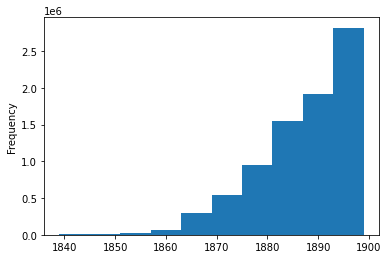

In [29]:
items_by_slice['Year'] = items_by_slice.index.map(lambda x: x[x.find('_')+1:x.find('_')+5])
items_by_slice['Year'] = pd.to_numeric(items_by_slice['Year'])
items_by_slice['Year'].plot(kind='hist')

We see that the later parts of the corpus massively outweigh the former. This is to be expected!

We can also get a sense of regional coverage. Here I load an independently generated dictionary matching newspaper codes with their full names.

In [8]:
with open('../Dataset/processed-data/meta/codes2names.pickle', 'rb') as fin:
    codes2names = pickle.load(fin)

names2codes = {}
for k, v in codes2names.items():
    names2codes[v] = k

input_string = """Albertland Gazette 	Auckland
Auckland Chronicle and New Zealand Colonist 	Auckland
Auckland Star 	Auckland
Auckland Times 	Auckland
Daily Southern Cross 	Auckland
New Zealand Herald 	Auckland
New Zealand Herald and Auckland Gazette 	Auckland
New Zealander 	Auckland
Observer 	Auckland
Bay of Plenty Times 	Bay of Plenty
Hot Lakes Chronicle 	Bay of Plenty
Akaroa Mail and Banks Peninsula Advertiser 	Canterbury
Ashburton Guardian 	Canterbury
Ashburton Herald 	Canterbury
Ellesmere Guardian 	Canterbury
Globe 	Canterbury
Lyttelton Times 	Canterbury
Oxford Observer 	Canterbury
Press 	Canterbury
South Canterbury Times 	Canterbury
Star (Christchurch) 	Canterbury
Temuka Leader 	Canterbury
Timaru Herald 	Canterbury
Waimate Daily Advertiser 	Canterbury
Matariki 	Gisborne
Poverty Bay Herald 	Gisborne
Takitimu 	Gisborne
Bush Advocate 	Hawke's Bay
Daily Telegraph 	Hawke's Bay
Hastings Standard 	Hawke's Bay
Hawke's Bay Herald 	Hawke's Bay
Hawke's Bay Times 	Hawke's Bay
Hawke's Bay Weekly Times 	Hawke's Bay
Waipawa Mail 	Hawke's Bay
Feilding Star 	Manawatu-Wanganui
Manawatu Herald 	Manawatu-Wanganui
Manawatu Standard 	Manawatu-Wanganui
Manawatu Times 	Manawatu-Wanganui
Pahiatua Herald 	Manawatu-Wanganui
Wanganui Chronicle 	Manawatu-Wanganui
Wanganui Herald 	Manawatu-Wanganui
Woodville Examiner 	Manawatu-Wanganui
Marlborough Daily Times 	Marlborough
Marlborough Express 	Marlborough
Marlborough Press 	Marlborough
Pelorus Guardian and Miners' Advocate. 	Marlborough
Anglo-Maori Warder 	National
Aotearoa : he Nupepa ma nga Tangata Maori 	National
Haeata 	National
Hiiringa i te Whitu 	National
Hokioi o Nui-Tireni, e rere atuna 	National
Huia Tangata Kotahi 	National
Jubilee : Te Tiupiri 	National
Kahiti Tuturu mo Aotearoa, me te Waipounamu 	National
Korimako 	National
Maori Messenger : Te Karere Maori 	National
Pihoihoi Mokemoke i Runga i te Tuanui 	National
Saturday Advertiser 	National
Waka Maori 	National
Wananga 	National
Whetu o te Tau 	National
Colonist 	Nelson
Golden Bay Argus 	Nelson
Nelson Evening Mail 	Nelson
Nelson Examiner and New Zealand Chronicle 	Nelson
New Zealand Advertiser and Bay of Islands Gazette 	Northland
Northern Advocate 	Northland
Bruce Herald 	Otago
Clutha Leader 	Otago
Cromwell Argus 	Otago
Dunstan Times 	Otago
Evening Star 	Otago
Lake County Press 	Otago
Lake Wakatip Mail 	Otago
Mataura Ensign 	Otago
Mount Ida Chronicle 	Otago
Mt Benger Mail 	Otago
North Otago Times 	Otago
Oamaru Mail 	Otago
Otago Daily Times 	Otago
Otago Witness 	Otago
Southern Cross 	Otago
Southland Times 	Otago
Tuapeka Times 	Otago
Western Star 	Otago
Samoa Times and South Sea Advertiser 	Samoa
Samoa Times and South Sea Gazette 	Samoa
Samoa Weekly Herald 	Samoa
Hawera & Normanby Star 	Taranaki
Opunake Times 	Taranaki
Patea Mail 	Taranaki
Taranaki Herald 	Taranaki
Ohinemuri Gazette 	Waikato
Paki o Matariki 	Waikato
Te Aroha News 	Waikato
Thames Advertiser 	Waikato
Thames Guardian and Mining Record 	Waikato
Thames Star 	Waikato
Waikato Argus 	Waikato
Waikato Times 	Waikato
Evening Post 	Wellington
Karere o Poneke 	Wellington
New Zealand Colonist and Port Nicholson Advertiser 	Wellington
New Zealand Gazette and Wellington Spectator 	Wellington
New Zealand Mail 	Wellington
New Zealand Spectator and Cook's Strait Guardian 	Wellington
New Zealand Times 	Wellington
Puke ki Hikurangi 	Wellington
Victoria Times 	Wellington
Wairarapa Daily Times 	Wellington
Wairarapa Standard 	Wellington
Wellington Independent 	Wellington
Charleston Argus 	West Coast
Grey River Argus 	West Coast
Inangahua Times 	West Coast
Kumara Times 	West Coast
Lyell Times and Central Buller Gazette 	West Coast
West Coast Times 	West Coast
Westport Times 	West Coast"""

code2region = {}
pairs = [pair_string.split(' \t') for pair_string in input_string.split('\n')]

for pair in pairs:
    newspaper = pair[0]
    region = pair[1]
    try:
        code = names2codes[newspaper]
        code2region[code] = region
    except KeyError:
        pass

In [10]:
#Straggler
code2region['TS'] = 'Canterbury'

We save the codes2region dictionary for future use.

In [7]:
with open('../Dataset/processed-data/meta/code2region.pickle', 'wb') as fout:
    pickle.dump(code2region, fout)

NameError: name 'code2region' is not defined

We can now look at some distributions of items across regions.

In [11]:
items_by_slice['Newspaper'] = items_by_slice.index.map(lambda x: x[0:x.find('_')])
items_by_slice['Region'] = items_by_slice['Newspaper'].map(lambda x: code2region[x])

<AxesSubplot:>

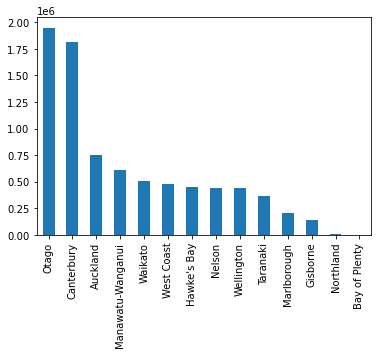

In [38]:
items_by_slice['Region'].value_counts().plot(kind='bar')

Massive over representation of Otago and Canterbury in this dataset (when measured by number of distinct newspaper items). We had better keep this in mind when reasoning about any corpora we generate!

In [4]:
items_by_slice = pd.read_pickle('../Dataset/processed-data/meta/items_by_slice.tar.gz')

In [16]:
items_by_slice[items_by_slice['Region'] == "Bay of Plenty"]

,Title,Slice,Newspaper,Region
HLC_18970102_ARTICLE1,VISITORS' LIST.,3,HLC,Bay of Plenty
HLC_18970102_ARTICLE2,THE HOT LAKES CHRONICLE AND Tourists' Journal....,3,HLC,Bay of Plenty
HLC_18970102_ARTICLE3,LOCAL NEWS AND NOTES.,3,HLC,Bay of Plenty
HLC_18970102_ARTICLE4,TO TIKITERE ON A TRIO OF BIKES.,3,HLC,Bay of Plenty
HLC_18970102_ARTICLE5,THE MAN WHO KNOWS THE ROAD.,3,HLC,Bay of Plenty
...,...,...,...,...
HLC_18951225_ARTICLE6,ROBERTSON'S NEW STABLES.,3,HLC,Bay of Plenty
HLC_18951225_ARTICLE7,TOWN BOARD MEETING.,3,HLC,Bay of Plenty
HLC_18951225_ARTICLE8,CHURCH CONCERT.,3,HLC,Bay of Plenty
HLC_18951225_ARTICLE9,SCHOOL PICNIC.,3,HLC,Bay of Plenty


## Next Steps

### In corpus construction method

Having processed and stored what we require from the raw METS/ALTO data, the next step is to begin the first iteration of corpus construction. This begins in the "Corpus Exploration" notebook.

### For this code

The way that METS files and ALTO files are handled is not symetrical. We pass XML roots to our functions for pages (ALTO files) and an XML file as raw text to our function for the METS file. This could be tidied up in a future iteration.